# Script IDF

## Librairies

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from functools import partial

## Données et traitement: Extraction des Maximas par blocs: 

L'extraction des données est la même que pour les autres scripts, mais ici eviter d'utiliser temp=1 car la methode finale est basée sur l'idée d'un processus en minutes

In [3]:
Station = ['Aigle','Dole','Payerne','Fretaz','Pully','Nyon','Moleson']
num_sta = 6 # Choix de la station
Annees = [['8095','9524'],['8024']]
Temporalité = ['Minutes','Heures']
Temporalité2 = ['10 Minutes', 'Heures']
time_format = ['%M','']
temp = 0 # Choix du type de données (Horaire: 1 ou par 10 minutes: 0)

if temp == 1:
    raise PermissionError("Choisissez temp=0")
df=pd.read_csv("../Database/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][0]+".txt", sep=";", low_memory=False)

# Si on a les données minutes alors elles sont séparées en plusieurs fichier de 1980 à 2025 et il convient de les fusionner
if Temporalité[temp] == 'Minutes':
    df_temp=pd.read_csv("../Database/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][1]+".txt", sep=";", low_memory=False)
    last_time = df['time'].iloc[-1]
    df_temp_no_overlap= df_temp[df_temp['time'] > last_time]
    df = pd.concat([df, df_temp_no_overlap], ignore_index=True) # Ici on fusionne les données de 80 à 95 avec 95 à 25

del df['stn']
df.time = pd.to_datetime(df['time'], yearfirst=True, utc=False, format='%Y%m%d%H'+time_format[temp])
df.replace('-', 0, inplace=True)
df = df[~df.time.dt.year.isin([2025, 1980])] # J'enlève les années incomplètes manuellement

In [4]:
N = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
treshold = 4

colonne_valeur = df.columns[1]

width_mobile = 25
num_mobiles = df['time'].dt.year.max() - df['time'].dt.year.min() - width_mobile + 1
first_year = df['time'].dt.year.min()
df[colonne_valeur] = pd.to_numeric(df[colonne_valeur])

check = np.zeros(shape=[num_mobiles, len(N)])

maximas = np.zeros(shape=[num_mobiles, len(N), width_mobile])
results = []

for j in range(num_mobiles):
    year_slice = []
    print(f'Years: {first_year+j}-{first_year+j+width_mobile} \n')
    for i,n in enumerate(N):
        treshold_temp = treshold/(n**(0.6))
        df_temp = df[(df['time'].dt.year >= first_year+j) & (df['time'].dt.year < first_year + j + width_mobile)].copy()
        rows_to_keep = len(df_temp) - (len(df_temp) % n)
        df_temp = df_temp.iloc[:rows_to_keep]
        df_temp['group'] = np.floor(df_temp.index / n)
        df_temp['averaged'] = df_temp.groupby('group')[colonne_valeur].transform('mean')
        exceeding = df_temp[df_temp['averaged'] > treshold_temp]
        unique_by_group = exceeding.drop_duplicates(subset='group')
        pdmaximas = unique_by_group['averaged'].values
        del df_temp
        print(len(pdmaximas))
        year_slice.append(np.sort(np.array(pdmaximas))[::-1])
    results.append(year_slice)

print('\nDonnées sélectionnées: \n\n\tStation: '+Station[num_sta]+'\n\tTemporalité: '+Temporalité2[temp])

Years: 1982-2007 

112
113
93
88
87
83
84
79
79
77
69
74
Years: 1983-2008 

126
126
104
97
94
92
92
89
90
85
77
83
Years: 1984-2009 

125
127
105
99
95
93
93
91
89
85
78
83
Years: 1985-2010 

125
128
107
104
96
97
96
93
90
87
79
84
Years: 1986-2011 

132
136
113
109
99
101
101
97
94
89
83
87
Years: 1987-2012 

135
137
115
110
100
103
102
99
94
90
84
86
Years: 1988-2013 

128
130
111
104
93
99
93
95
90
86
84
85
Years: 1989-2014 

127
134
114
107
94
100
95
96
91
88
85
83
Years: 1990-2015 

140
144
123
118
107
110
103
104
104
103
98
94
Years: 1991-2016 

136
138
117
116
106
110
102
106
105
107
100
98
Years: 1992-2017 

135
138
118
119
109
112
103
108
107
107
101
100
Years: 1993-2018 

138
139
121
123
113
115
106
111
111
110
107
104
Years: 1994-2019 

143
143
125
128
114
120
112
115
114
111
109
107
Years: 1995-2020 

148
152
131
131
119
126
118
120
117
117
113
111
Years: 1996-2021 

146
148
127
130
119
126
118
124
117
118
116
114
Years: 1997-2022 

157
155
133
138
126
132
125
130
123
124
1

# Ajustement des données à la loi de Gumbel:

### Par la méthode des moments de probabilité pondérés que je bootstrap pour obtenir l'erreur empirique sur mes quantiles

In [24]:
import lmoments3 as lm
import lmoments3.distr as lmdist

parametres = np.zeros(shape=[num_mobiles,len(N),3])

T = np.array([2,5,10,20,50,100])
quantile_levels =1-1/T

n_boot = 1000
quantile_temp = np.zeros(shape=[n_boot,len(T)])
quantile_estimates = np.zeros(shape=[num_mobiles, len(N), len(T)])
lower_quantile = np.zeros(shape=[num_mobiles, len(N), len(T)], dtype=float)
upper_quantile = np.zeros(shape=[num_mobiles, len(N), len(T)], dtype=float)

# data = your exceedances
for j in range(num_mobiles):
    for i, n in enumerate(N):
        for b in range(n_boot):
            sample = np.random.choice(results[j][i], size=len(results[j][i]), replace=True)
            fit = lmdist.gpa.lmom_fit(sample)
            quantile_temp[b, :] = stats.genpareto.ppf(quantile_levels, c=fit['c'], scale=fit['scale'], loc=fit['loc'])
        lower_quantile[j,i] = np.percentile(quantile_temp, 2.5, axis=0)
        upper_quantile[j,i] = np.percentile(quantile_temp, 97.5, axis=0)
        quantile_estimates[j,i] = np.mean(quantile_temp, axis=0)

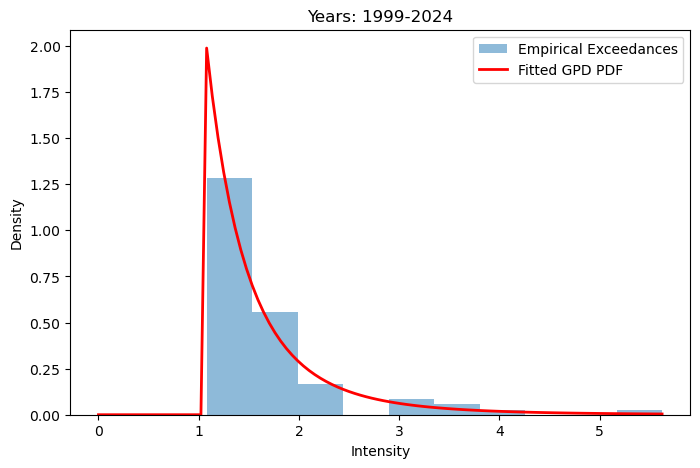

79


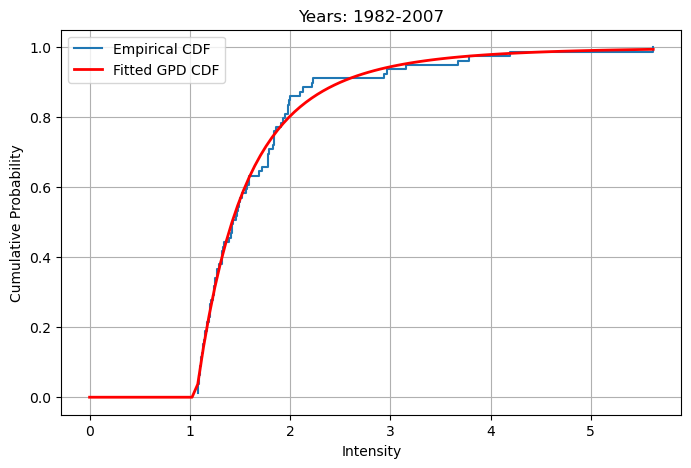

In [5]:
w=0
i=8

plt.figure(figsize=(8,5))
plt.hist(results[w][i], bins=10, density=True, alpha=0.5, label="Empirical Exceedances")
x = np.linspace(0, results[w][i].max(), 100)
plt.plot(x, stats.genpareto.pdf(x, parametres[w,i,0], loc=parametres[w,i,1], scale=parametres[w,i,2]), 'r-', lw=2, label="Fitted GPD PDF")
plt.title(f'Years: {first_year+j}-{first_year+j+width_mobile}')
plt.ylabel("Density")
plt.xlabel(f'Intensity')
plt.legend()
plt.show()

# Plot cumulative distribution (CDF)
plt.figure(figsize=(8,5))
# Empirical CDF
print(len(results[w][i]))
sorted_data = np.sort(results[w][i])
emp_cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
plt.step(sorted_data, emp_cdf, where='post', label="Empirical CDF")
# Fitted GPD CDF
plt.plot(x, stats.genpareto.cdf(x, parametres[w,i,0], loc=parametres[w,i,1], scale=parametres[w,i,2]), 'r-', lw=2, label="Fitted GPD CDF")
plt.xlabel(f'Intensity')
plt.ylabel("Cumulative Probability")
plt.title(f'Years: {first_year+w}-{first_year+w+width_mobile}')
plt.legend()
plt.grid(True)
plt.show()

## Plots Méthode numéro 2

In [25]:
def montana_complexe(a,b,n,N):
    return n+a*N**(b)

def montana_complexe_2D(a,b,n,N):
    return n[:,None] + a[:,None]*(N[None,:]**b[:,None])

def residuals_2(params, N, Frequencies):
    a = params[0]
    b = params[1]
    n = params[2]
    model = montana_complexe(a,b,n,N)
    residual = model - Frequencies
    return residual

In [26]:
import scipy.optimize

a = np.zeros([num_mobiles,len(T)])
b = np.zeros([num_mobiles,len(T)])
n = np.zeros([num_mobiles,len(T)])
Frequencies = np.array(quantile_estimates, dtype=float)

for j in range(num_mobiles): 
    for i, t in enumerate(T):
        result = scipy.optimize.least_squares(residuals_2, x0=[a[j,i],b[j,i],n[j,i]], args=(N, Frequencies[j,:,i]))
        a[j,i] = result.x[0]
        b[j,i] = result.x[1]
        n[j,i] = result.x[2]

In [29]:
def check_non_numeric(arr, name):
    arr_flat = np.array(arr).flatten()
    for idx, val in enumerate(arr_flat):
        if np.isnan(val):
            print(f"NaN in {name} at index {idx}")
        if np.isinf(val):
            print(f"Inf in {name} at index {idx}")

# Example usage for your arrays:
for j in range(num_mobiles):
    for i in range(len(T)):
        check_non_numeric(Frequencies[j,:,i], "Frequencies")
        check_non_numeric(lower_quantile[j,:,i], "lower_quantile")
        check_non_numeric(upper_quantile[j,:,i], "upper_quantile")

### Plot de la deuxième méthode

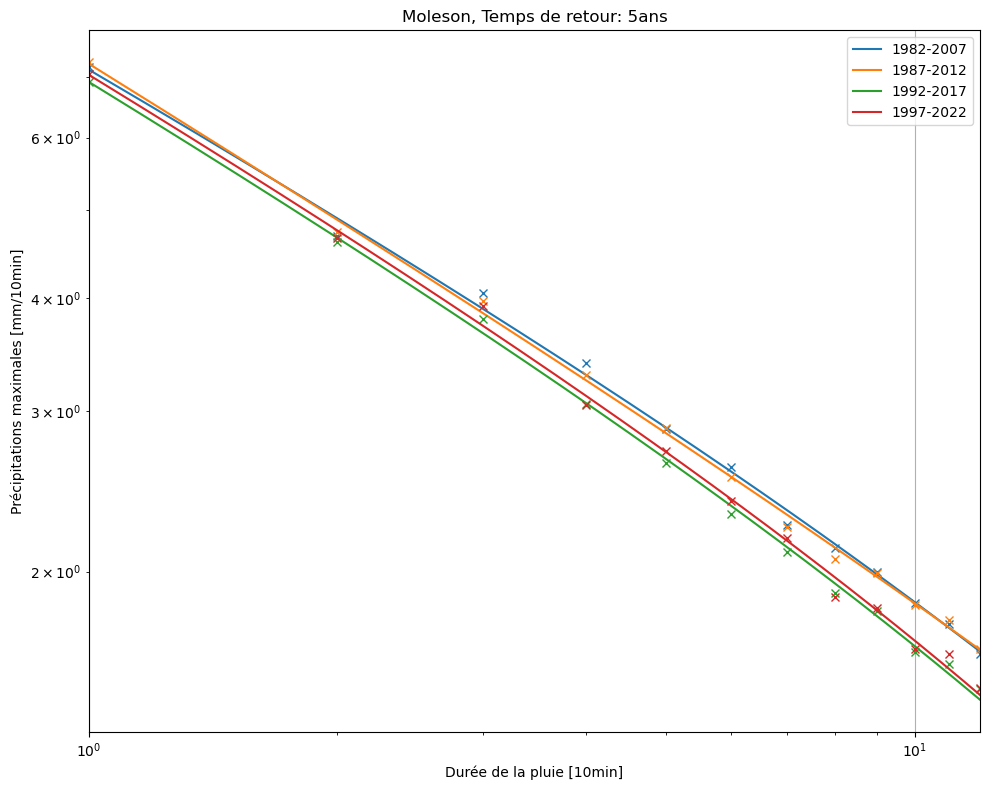

In [32]:
plt.figure(figsize=(10,8))
plt.subplot()
j = 1
for i, w in enumerate(range(num_mobiles)):
    if w%5==0:
        p1, = plt.plot(np.linspace(N[0],N[-1],1000), montana_complexe(a[i,j],b[i,j],n[i,j],np.linspace(N[0],N[-1],1000)), '-', label=f'{first_year+i}-{first_year+i+width_mobile}')
        color = p1.get_color()
        plt.plot(N, Frequencies[i,:,j],'x', color=color)
plt.xlabel('Durée de la pluie [10min]')
plt.ylabel('Précipitations maximales [mm/10min]')
plt.title(Station[num_sta]+f', Temps de retour: {T[j]}ans')
plt.xscale('log')
plt.yscale('log')
plt.xlim(N[0],N[-1])
#plt.ylim(2,4)
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

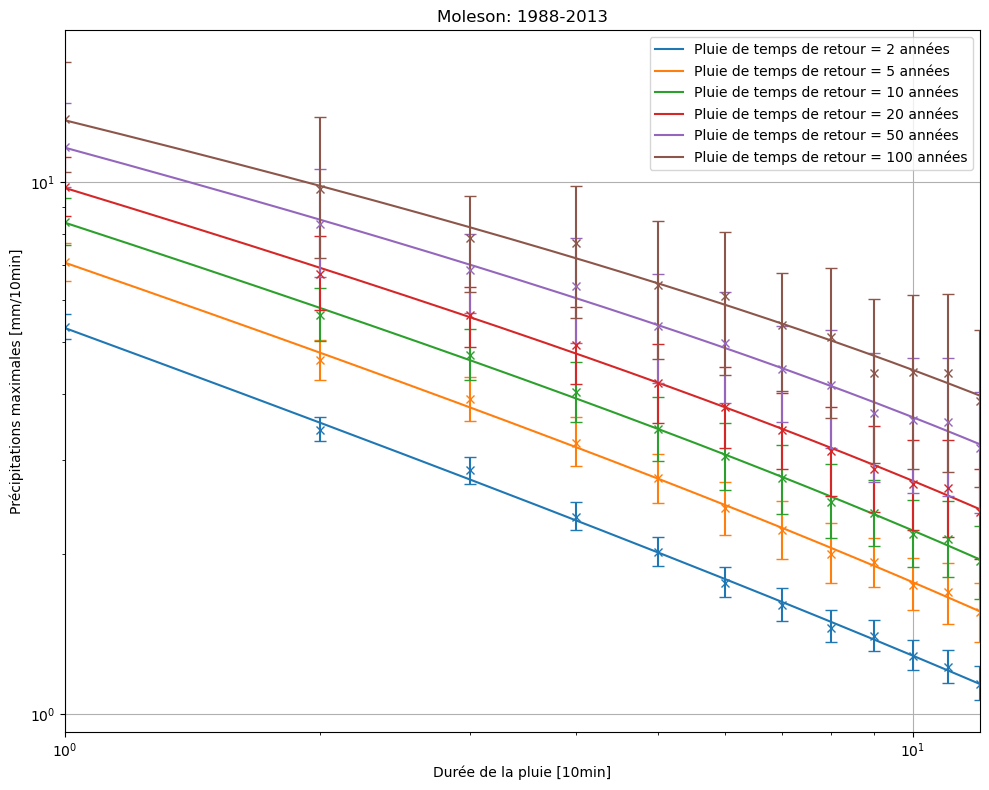

In [42]:
plt.figure(figsize=(10,8))
plt.subplot()
j = 6
for i, t in enumerate(T):
    p1, = plt.plot(np.linspace(N[0],N[-1],1000), montana_complexe(a[j,i],b[j,i],n[j,i],np.linspace(N[0],N[-1],1000)), '-', label=f'Pluie de temps de retour = {t} années')
    color = p1.get_color()
    freq_err = np.array([Frequencies[j,:,i]-lower_quantile[j,:,i],upper_quantile[j,:,i]-Frequencies[j,:,i]],dtype=float)
    plt.errorbar(N, Frequencies[j,:,i],yerr=freq_err,fmt='x', color=color, capsize=4)
plt.xlabel('Durée de la pluie [10min]')
plt.ylabel('Précipitations maximales [mm/10min]')
plt.title(Station[num_sta]+f': {first_year+j}-{first_year+j+width_mobile}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(N[0],N[-1])
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Computing the trend

In [44]:
def curves_diff(i1,i2,agg,precision):
    N = np.arange(agg[0],agg[-1],precision)
    mtn1 = montana_complexe_2D(a[:,i1],b[:,i1],n[:,i1],N)
    mtn2 = montana_complexe_2D(a[:,i2],b[:,i2],n[:,i2],N)
    return np.sum(mtn2 - mtn1, axis=1) / len(N)

2
5
10
20
50
100


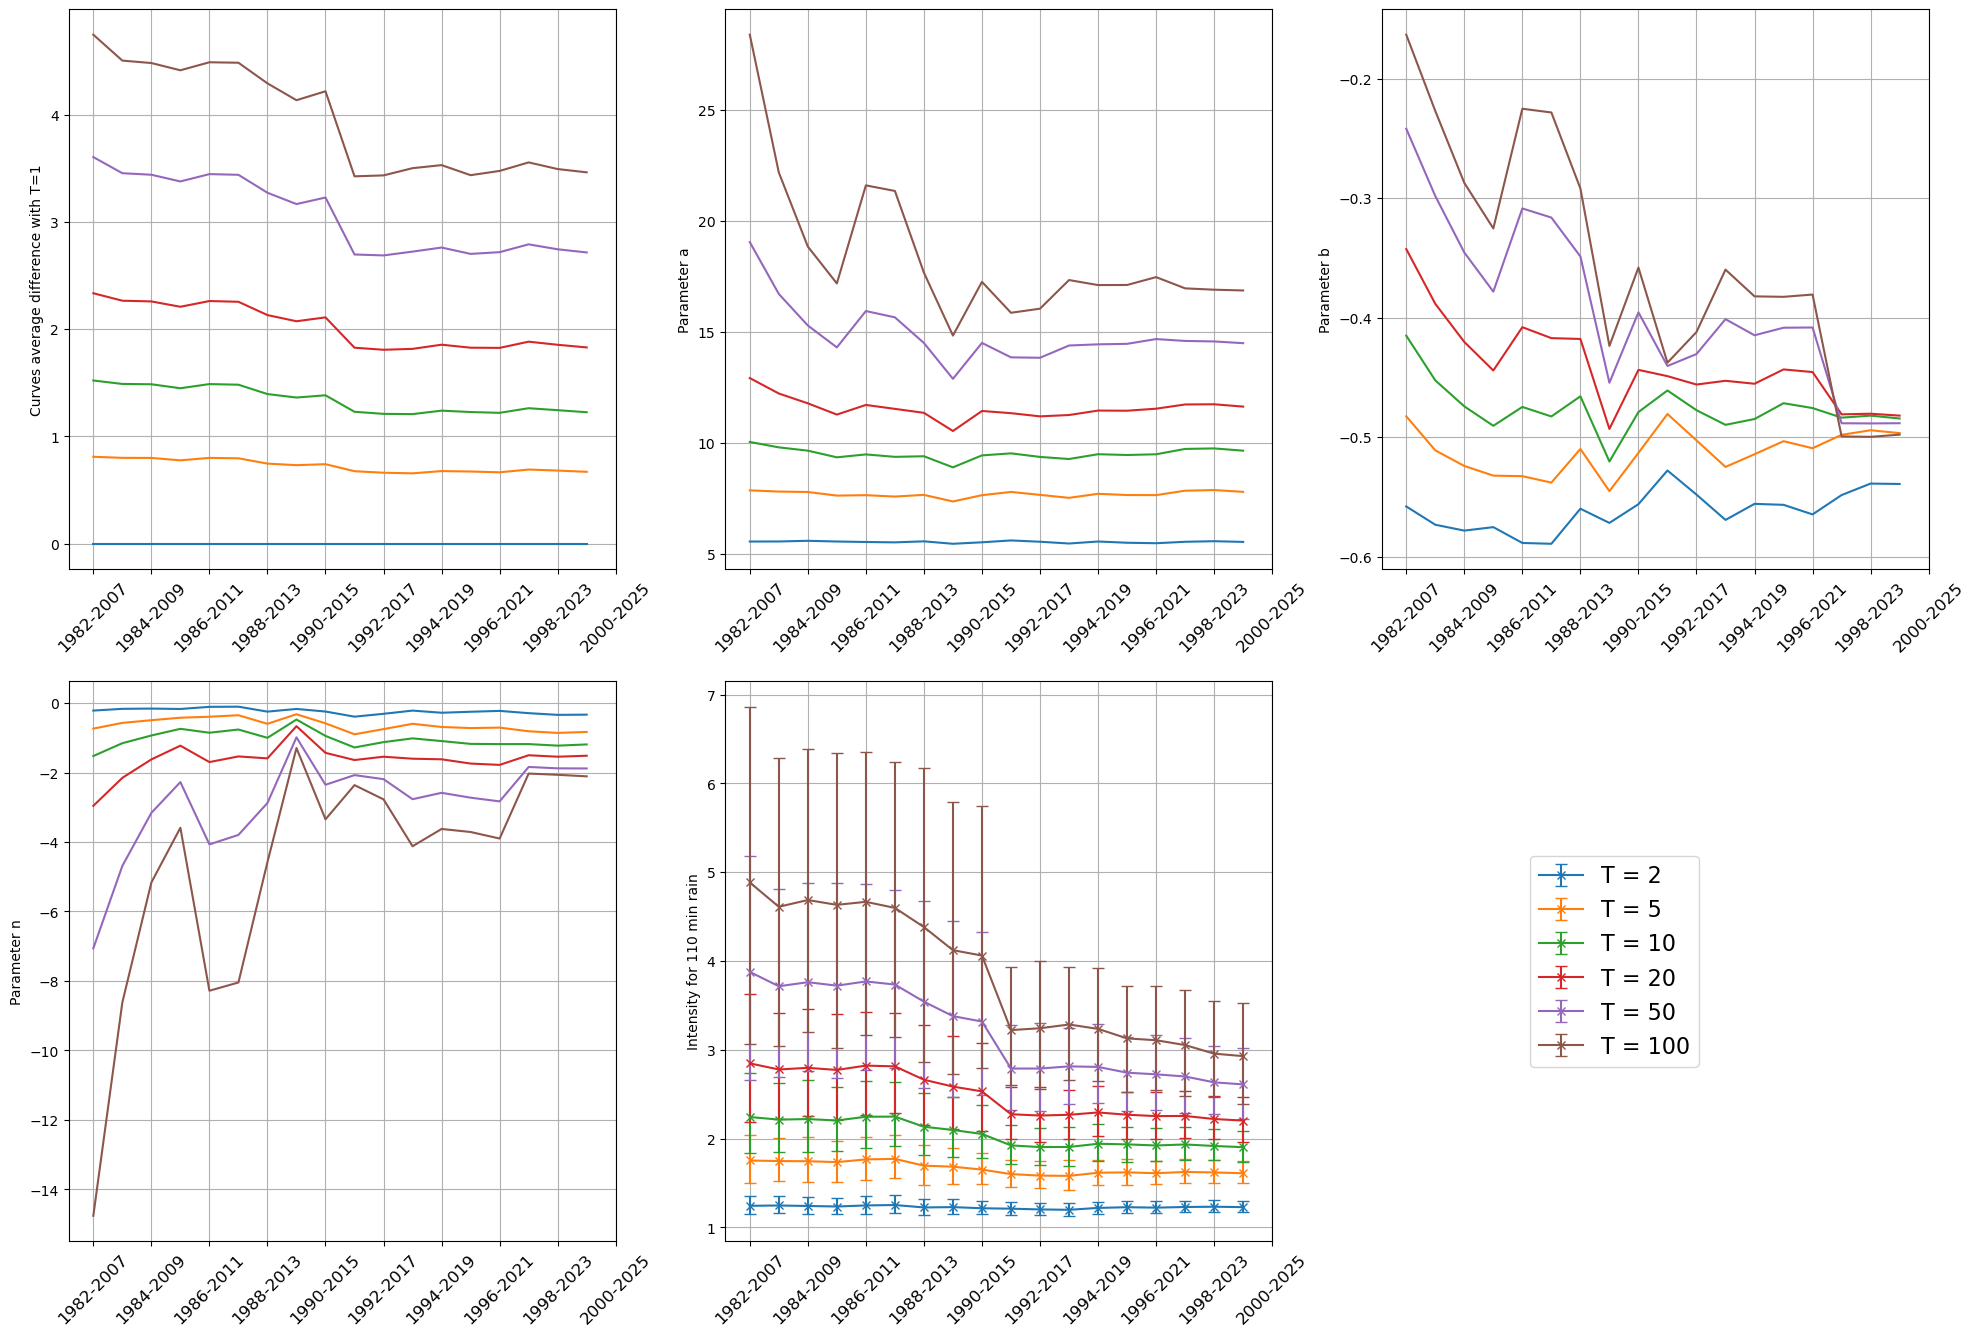

In [48]:
i1 = 0
k=10
x_labels = [f"{first_year+2*i}-{first_year+2*i+width_mobile}" for i in range(num_mobiles//2+1)]

plt.figure(figsize=(24, 16))

for i, t in enumerate(T):
    print(t)
    plt.subplot(2,3,1)
    plt.plot(1981+np.arange(num_mobiles),curves_diff(i1,i,N,0.01), label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Curves average difference with T=1')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    plt.subplot(2,3,2)
    plt.plot(1981+np.arange(num_mobiles),a[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter a')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    plt.subplot(2,3,3)
    plt.plot(1981+np.arange(num_mobiles),b[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter b')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    plt.subplot(2,3,4)
    plt.plot(1981+np.arange(num_mobiles),n[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter n')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    freq_err = np.array([Frequencies[:,k,i]-lower_quantile[:,k,i],upper_quantile[:,k,i]-Frequencies[:,k,i]],dtype=float)

    plt.subplot(2,3,5)
    plt.errorbar(1981+np.arange(num_mobiles), Frequencies[:,k,i], yerr=freq_err, fmt='x-', capsize=4, label=f'T = {t}')
    plt.grid('on')
    plt.ylabel(f'Intensity for {(k+1)*10} min rain')
    plt.legend(loc='center right', bbox_to_anchor=(1.8,0.5), fontsize=16)
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)